In [75]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pydot


In [76]:
class TreeNode:
    def __init__(self, feature=None, threshold=None, left=None, right=None, label=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.label = label

In [77]:
# Function to load a dataset from a file
def load_dataset(filename):
    with open(filename, "r") as file:
        data = [line.strip().split() for line in file]

    data = np.array(data, dtype=float)
    x = data[:, :-1]
    y = data[:, -1]
    return x, y

# Function to calculate the entropy of a dataset
def calculate_entropy(y):
    unique_classes, class_counts = np.unique(y, return_counts=True)
    total_samples = len(y)
    if len(y) == 0:
      return 0
    entropy = 0
    for count in class_counts:
        p = count / total_samples
        entropy -= p * math.log2(p)
    return entropy

# # Convert the decision tree into logic rules
# def tree_to_logic_rules(node, feature_names, rules=None, current_rule=None):
#     if rules is None:
#         rules = []

#     if current_rule is None:
#         current_rule = []

#     if node.label is not None:
#         current_rule.append(f"y = {int(node.label)}")
#         rules.append(" AND ".join(current_rule))
#     else:
#         current_rule.append(f"{feature_names[node.feature]} >= {node.threshold}")
#         tree_to_logic_rules(node.left, feature_names, rules, current_rule.copy())
#         current_rule[-1] = f"{feature_names[node.feature]} < {node.threshold}"
#         tree_to_logic_rules(node.right, feature_names, rules, current_rule.copy())

#     return rules

# Function to print the tree
def print_tree(node, indent=""):
    if node.label is not None:
        print(indent + f"y = {int(node.label)}")
    else:
        print(indent + f"If {feature_names[node.feature]} >= {node.threshold}:")
        print_tree(node.left, indent + "  ")
        print(indent + f"Else:")
        print_tree(node.right, indent + "  ")

# Calculate split info
def calculate_split_info(left, right, total):
    split_info = 0
    for group in [left, right]:
        ratio = len(group) / total
        if ratio > 0.0:
            split_info -= ratio * math.log2(ratio)
    return split_info


# Function to find the best split in the dataset using information gain ratio
def find_best_split(x, y):
    best_split = None
    best_info_gain_ratio = -1

    for feature in range(x.shape[1]):
        unique_values = np.unique(x[:, feature])
        for threshold in unique_values:
            left_indices = np.where(x[:, feature] >= threshold)[0]
            right_indices = np.where(x[:, feature] < threshold)[0]

            if len(left_indices) == 0 or len(right_indices) == 0:
                continue

            left_entropy = calculate_entropy(y[left_indices])
            right_entropy = calculate_entropy(y[right_indices])
            total_entropy = calculate_entropy(y)

            split_info = calculate_split_info(y[left_indices], y[right_indices], len(y))
            if split_info == 0:
                continue

            information_gain = total_entropy - (len(left_indices) / len(y)) * left_entropy - (len(right_indices) / len(y)) * right_entropy
            information_gain_ratio = information_gain / split_info

            if information_gain_ratio > best_info_gain_ratio:
                best_info_gain_ratio = information_gain_ratio
                best_split = (feature, threshold, left_indices, right_indices)

    return best_split

# Function to check if all possible splits of a dataset result in decision tree nodes
# with information gain ratios less than or equal to zero.
def all_split_zero_gain_ratio(x, y):
    for feature in range(x.shape[1]):
        unique_values = np.unique(x[:, feature])
        for threshold in unique_values:
            left_indices = np.where(x[:, feature] >= threshold)[0]
            right_indices = np.where(x[:, feature] < threshold)[0]

            if len(left_indices) == 0 or len(right_indices) == 0:
                continue

            left_entropy = calculate_entropy(y[left_indices])
            right_entropy = calculate_entropy(y[right_indices])
            total_entropy = calculate_entropy(y)

            split_info = calculate_split_info(y[left_indices], y[right_indices], len(y))
            if split_info == 0:
                return False

            information_gain = total_entropy - (len(left_indices) / len(y)) * left_entropy - (len(right_indices) / len(y)) * right_entropy
            information_gain_ratio = information_gain / split_info

            if information_gain_ratio > 0.0:
                return False
    return True


def majority_vote(y):
    classes, counts = np.unique(y, return_counts=True)
    if len(classes) <= 1 or counts[0] == counts[1]:
        return 1  # Predict y=1 when there's no majority class or tie
    else:
        return classes[np.argmax(counts)]

#Recursive function to build tree
def build_decision_tree_recursive(x, y):
    # Stopping criteria
    if len(set(y)) == 1:
        return TreeNode(label=y[0])
    if len(y) == 0:
        return TreeNode(label=1)  # Predict y=1 when there's no data
    if all_split_zero_gain_ratio(x, y):
        return TreeNode(label=majority_vote(y)) # Predict y=majority class when all splits have zero gain

    # Find the best split
    best_split = find_best_split(x, y)

    if best_split is None:
        return TreeNode(label=majority_vote(y)) # Predict y=majority class when no further split provides information gain

    feature, threshold, left_indices, right_indices = best_split
    left_subtree = build_decision_tree_recursive(x[left_indices], y[left_indices])
    right_subtree = build_decision_tree_recursive(x[right_indices], y[right_indices])

    return TreeNode(feature=feature, threshold=threshold, left=left_subtree, right=right_subtree)

# Function to build a decision tree
def build_decision_tree(x, y):
  return build_decision_tree_recursive(x, y)

# Function to create a scatter plot
def scatter_plot(x1, x2, y, filename):
    colors = ['red' if label == 0 else 'blue' for label in y]
    plt.figure(figsize=(8, 6))
    plt.scatter(x1, x2, c=colors, marker='o', s=100)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.title('Scatter Plot of Training Set')
    plt.grid(True)
    plt.savefig(filename, format='pdf', bbox_inches='tight')
    plt.show()

#Function to plot decision boundary
def plot_decision_boundary(tree, X, y, title, save_filename=None):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
    Z = predict(tree, np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure()
    plt.contourf(xx, yy, Z, alpha=0.4)

    plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], marker='o', s=25, edgecolor='k', label='y=0')
    plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], marker='x', s=25, edgecolor='k', label='y=1')

    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.title(title)
    plt.grid(True)

    legend = plt.legend(loc='upper right', shadow=True)

    if save_filename:
        plt.savefig(save_filename)

    plt.show()

#Function to create scatter plot
def scatter_plot_func(x, y, class_labels, title, save_filename=None):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)

    for class_label in class_labels:
        plt.scatter(x[y == class_label][:, 0], x[y == class_label][:, 1], label=f'y = {class_label}', marker='o' if class_label == 0 else 's', s=30)

    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.title(f'Scatter Plot of {title}')
    plt.legend()

    plt.tight_layout()

    if save_filename:
        plt.savefig(save_filename)
    plt.show()


# Function to count nodes in the decision tree
def count_nodes(tree):
    if tree is None:
        return 0
    return 1 + count_nodes(tree.left) + count_nodes(tree.right)

# Function to predict using the decision tree
def predict(tree, X):
    y_pred = np.zeros(X.shape[0])
    for i, x in enumerate(X):
        current_node = tree
        while current_node.label is None:
            if x[current_node.feature] >= current_node.threshold:
                current_node = current_node.left
            else:
                current_node = current_node.right
        y_pred[i] = current_node.label
    return y_pred

#Function to visualize tree
def visualize_tree(tree, feature_names, class_names, filename):
    def build_dot(node, dot_graph):
        if node is None:
            return

        if node.label is not None:
            label = class_names[int(node.label)]
            dot_graph.add_node(pydot.Node(str(id(node)), label=label, shape="ellipse"))
        else:
            label = f"{feature_names[node.feature]} >= {node.threshold:.4f}"
            dot_graph.add_node(pydot.Node(str(id(node)), label=label, shape="box"))

            if node.left is not None:
                build_dot(node.left, dot_graph)
                dot_graph.add_edge(pydot.Edge(str(id(node)), str(id(node.left))))
            if node.right is not None:
                build_dot(node.right, dot_graph)
                dot_graph.add_edge(pydot.Edge(str(id(node)), str(id(node.right))))

    dot_graph = pydot.Dot(graph_type="digraph")
    build_dot(tree, dot_graph)
    dot_graph.write_png(filename)


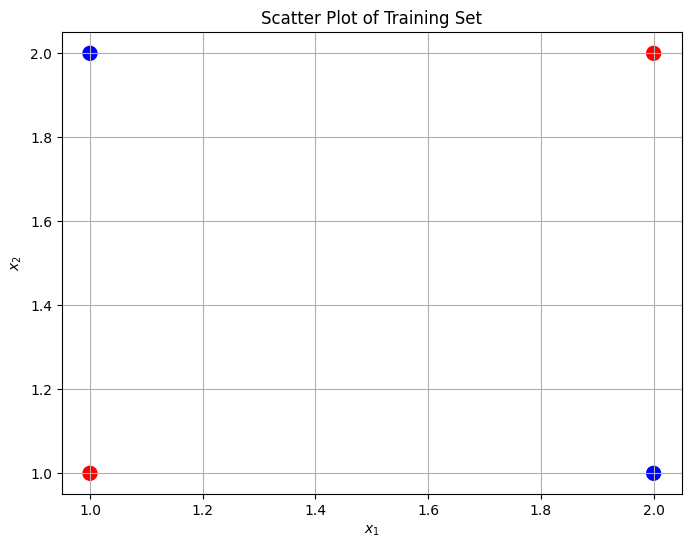

In [78]:
#QUESTION 2
# Load the dataset
x1 = [1, 1, 2, 2]
x2 = [1, 2, 1, 2]
y = [0, 1, 1, 0]

scatter_plot(x1, x2, y, 'scatter_plot.pdf')


In [79]:
# QUESTION 3
x, y = load_dataset("Druns.txt")

# Calculate the entropy of the entire dataset
entropy_dataset = calculate_entropy(y)

# Initialize variables to track the best split
best_information_gain_ratio = 0
best_split_feature = None
best_split_threshold = None

# Lists to store candidate splits, their information gains, and information gain ratios
candidate_splits = []

# Enumerate the candidate splits
for feature in range(x.shape[1]):
    unique_values = np.unique(x[:, feature])
    for threshold in unique_values:
        # Split the dataset based on the current feature and threshold
        left_indices = np.where(x[:, feature] >= threshold)[0]
        right_indices = np.where(x[:, feature] < threshold)[0]

        # Calculate the entropy of the left and right subsets
        left_entropy = calculate_entropy(y[left_indices]) if len(left_indices) > 0 else 0
        right_entropy = calculate_entropy(y[right_indices]) if len(right_indices) > 0 else 0

        # Calculate the information gain
        total_samples = len(y)
        split_entropy = (len(left_indices) / total_samples) * left_entropy + (len(right_indices) / total_samples) * right_entropy
        information_gain = entropy_dataset - split_entropy

        # Calculate the split information
        split_info = 0
        for subset_indices in [left_indices, right_indices]:
            subset_size = len(subset_indices)
            p = subset_size / total_samples
            split_info -= p * math.log2(p+1e-10)

        # Calculate information gain ratio
        if split_info == 0:
            information_gain_ratio = 0
        else:
            information_gain_ratio = information_gain / split_info

        # Update the lists with candidate splits
        candidate_splits.append((feature, threshold, information_gain, information_gain_ratio, split_entropy))


print("Candidate Splits and Information Gain (when entropy is 0) or Information Gain Ratio:")
for split in candidate_splits:
    feature, threshold, info_gain, info_gain_ratio, split_entropy = split

    # If entropy is zero, print mutual information (information gain)
    if math.isclose(info_gain_ratio, 0):
        print(f"Split feature: x{feature + 1}, Threshold: {threshold:.1f}, Information Gain: {info_gain:.4f}")
    # Always print information gain ratio
    else:
        print(f"Split feature: x{feature + 1}, Threshold: {threshold:.1f}, Information Gain Ratio: {info_gain_ratio:.4f}")

Candidate Splits and Information Gain (when entropy is 0) or Information Gain Ratio:
Split feature: x1, Threshold: 0.0, Information Gain: 0.0000
Split feature: x1, Threshold: 0.1, Information Gain Ratio: 0.1005
Split feature: x2, Threshold: -2.0, Information Gain: 0.0000
Split feature: x2, Threshold: -1.0, Information Gain Ratio: 0.1005
Split feature: x2, Threshold: 0.0, Information Gain Ratio: 0.0560
Split feature: x2, Threshold: 1.0, Information Gain Ratio: 0.0058
Split feature: x2, Threshold: 2.0, Information Gain Ratio: 0.0011
Split feature: x2, Threshold: 3.0, Information Gain Ratio: 0.0164
Split feature: x2, Threshold: 4.0, Information Gain Ratio: 0.0497
Split feature: x2, Threshold: 5.0, Information Gain Ratio: 0.1112
Split feature: x2, Threshold: 6.0, Information Gain Ratio: 0.2361
Split feature: x2, Threshold: 7.0, Information Gain Ratio: 0.0560
Split feature: x2, Threshold: 8.0, Information Gain Ratio: 0.4302


In [80]:
#QUESTION4
# Load the dataset from D3leaves.txt
x, y = load_dataset("D3leaves.txt")


# Build the decision tree
decision_tree = build_decision_tree(x, y)

# Define feature names for clarity
feature_names = ["x1", "x2"]
class_names = ["y = 0", "y = 1"]

# # Convert the decision tree into logic rules
# logic_rules = tree_to_logic_rules(decision_tree, feature_names)

# Print the decision tree
print("Decision Tree:")
print_tree(decision_tree)

# # Print the logic rules
# print("\nLogic Rules:")
# for rule in logic_rules:
#     print(rule)

filename = "decision_tree_q4.png"
visualize_tree(decision_tree, feature_names, class_names, filename)


Decision Tree:
If x1 >= 10.0:
  y = 1
Else:
  If x2 >= 3.0:
    y = 1
  Else:
    y = 0


In [81]:
#QUESTION 5
x1, y1 = load_dataset("D1.txt")

# Build the decision tree
decision_tree1 = build_decision_tree(x1, y1)

# Define feature names for clarity
feature_names = ["x1", "x2"]

# Print the decision tree
print("Decision Tree:")
print_tree(decision_tree1)

filename = "decision_tree_q5_1.png"
visualize_tree(decision_tree1, feature_names, class_names, filename)

x2, y2 = load_dataset("D2.txt")

# Build the decision tree
decision_tree2 = build_decision_tree(x2, y2)

# Define feature names
feature_names = ["x1", "x2"]

# Print the decision tree
print("\n\nDecision Tree:")
print_tree(decision_tree2)

filename = "decision_tree_q5_2.png"
visualize_tree(decision_tree2, feature_names, class_names, filename)


Decision Tree:
If x2 >= 0.201829:
  y = 1
Else:
  y = 0


Decision Tree:
If x1 >= 0.533076:
  If x2 >= 0.228007:
    If x2 >= 0.424906:
      y = 1
    Else:
      If x1 >= 0.708127:
        y = 1
      Else:
        If x2 >= 0.32625:
          If x1 >= 0.595471:
            If x1 >= 0.646007:
              y = 1
            Else:
              If x2 >= 0.403494:
                y = 1
              Else:
                y = 0
          Else:
            y = 0
        Else:
          y = 0
  Else:
    If x1 >= 0.887224:
      If x2 >= 0.037708:
        If x2 >= 0.082895:
          y = 1
        Else:
          If x1 >= 0.960783:
            y = 1
          Else:
            y = 0
      Else:
        y = 0
    Else:
      If x1 >= 0.850316:
        If x2 >= 0.169053:
          y = 1
        Else:
          y = 0
      Else:
        y = 0
Else:
  If x2 >= 0.88635:
    If x1 >= 0.041245:
      If x1 >= 0.104043:
        y = 1
      Else:
        If x1 >= 0.07642:
          y = 0
        El

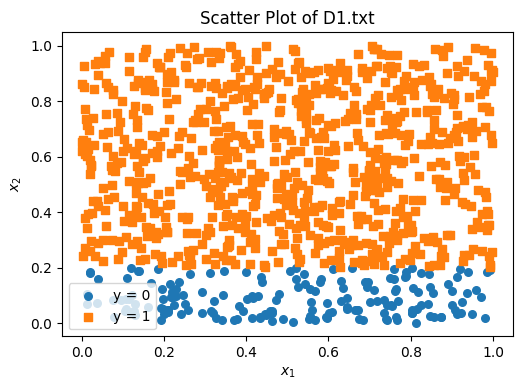

<ipython-input-77-48ad5c6b29ba>:178: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], marker='x', s=25, edgecolor='k', label='y=1')


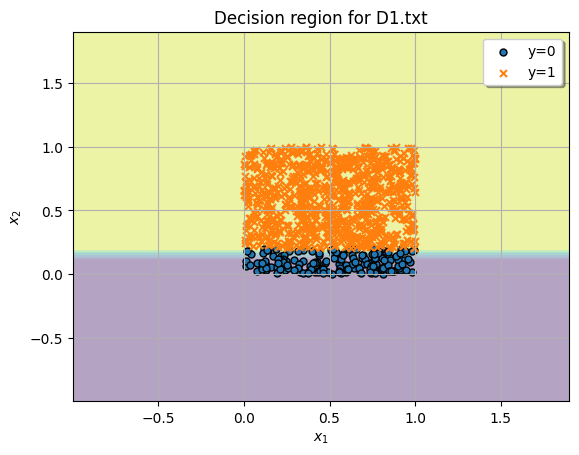

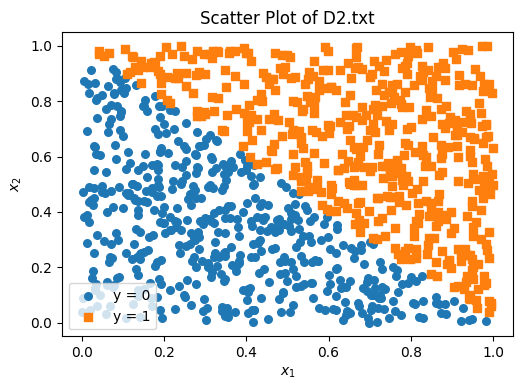

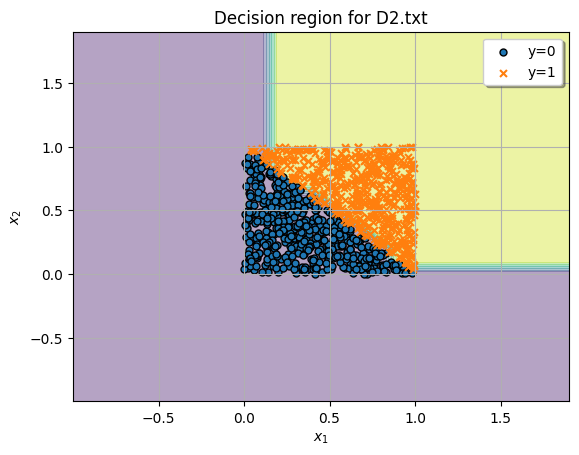

In [82]:
#QUESTION 6

# Scatter plot and decision boundary of D1
scatter_plot_func(x1, y1, [0, 1], 'D1.txt','scatter_plot_D1.png')
plot_decision_boundary(decision_tree1,x1,y1,"Decision region for D1.txt",'decision_boundary_D1.png')

# Scatter plot and decision boundary of D2
scatter_plot_func(x2, y2, [0, 1], 'D2.txt','scatter_plot_D2.png')
plot_decision_boundary(decision_tree2,x2,y2,"Decision region for D2.txt",'decision_boundary_D2.png')


<ipython-input-77-48ad5c6b29ba>:178: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], marker='x', s=25, edgecolor='k', label='y=1')


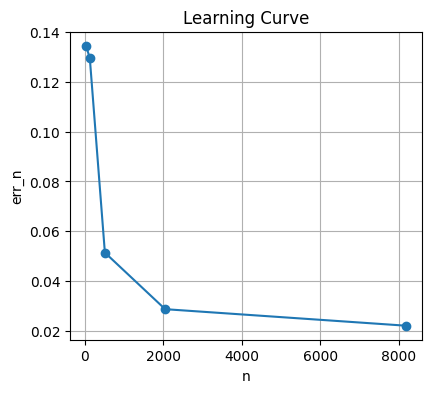

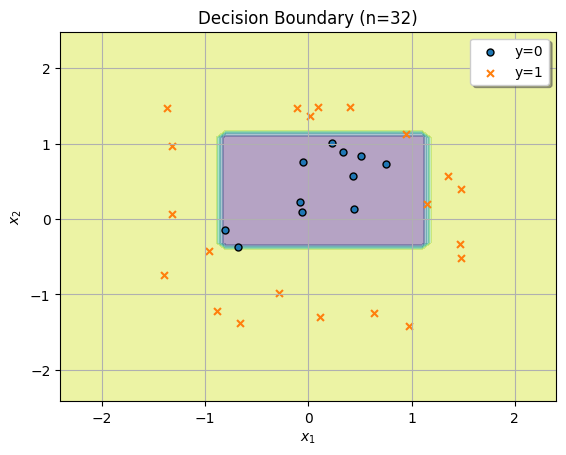

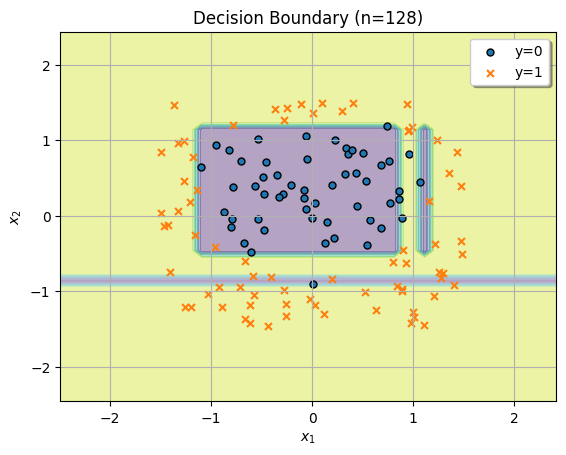

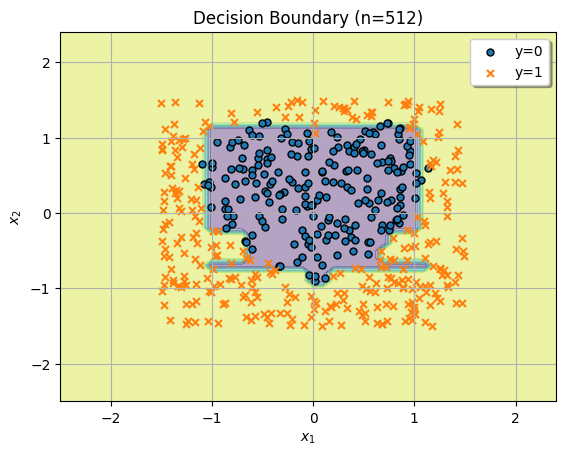

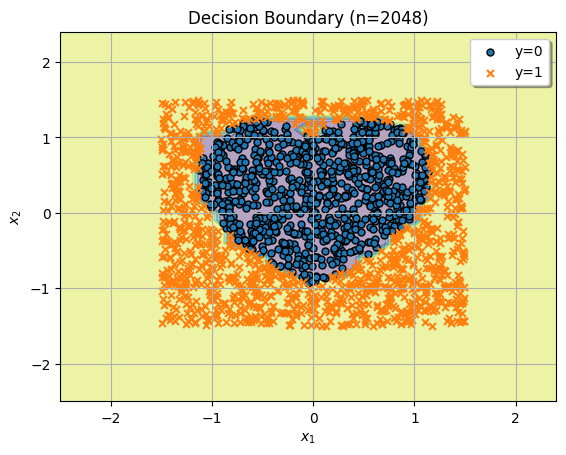

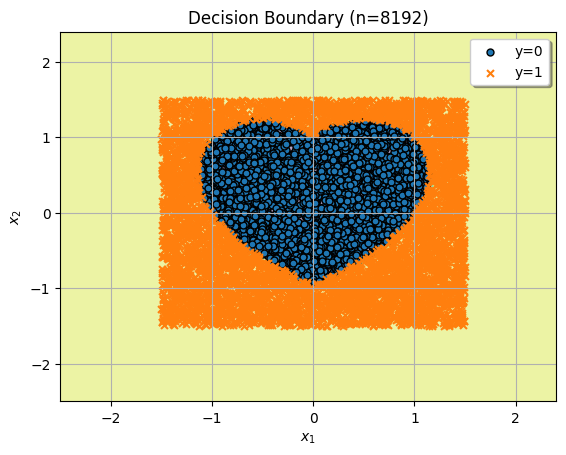

n=32, Number of Nodes=9, err_n=0.13440265486725664
n=128, Number of Nodes=25, err_n=0.12942477876106195
n=512, Number of Nodes=59, err_n=0.05143805309734513
n=2048, Number of Nodes=115, err_n=0.028761061946902654
n=8192, Number of Nodes=277, err_n=0.022123893805309734


In [83]:
#QUESTION 7

# Load the Dbig.txt dataset
data = np.loadtxt('Dbig.txt')

# Generate a random permutation for splitting
np.random.seed(42)
np.random.shuffle(data)

# Split the data into a candidate training set (8192 items) and a test set
num_train = 8192
X_train, y_train = data[:num_train, :-1], data[:num_train, -1]
X_test, y_test = data[num_train:, :-1], data[num_train:, -1]

# Initialize lists to store results
n_values = [32, 128, 512, 2048, 8192]
num_nodes = []
err_n = []

# Loop over different training set sizes
for n in n_values:
    X_train_n, y_train_n = X_train[:n], y_train[:n]

    # Build the decision tree
    decision_tree_q7 = build_decision_tree(X_train_n, y_train_n)
    num_nodes.append(count_nodes(decision_tree_q7))

    # Calculate and store the test error
    y_pred = predict(decision_tree_q7, X_test)
    test_error = np.mean(y_pred != y_test)
    err_n.append(test_error)

# Plot learning curve (test set error vs. training set size)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)

plt.plot(n_values, err_n, marker='o', linestyle='-')
plt.title('Learning Curve')
plt.xlabel('n')
plt.ylabel('err_n')
plt.grid(True)
plt.savefig('learning_curve.png')

# Plot decision boundary for different training set sizes
for i, n in enumerate(n_values):
    X_train_n, y_train_n = X_train[:n], y_train[:n]
    decision_tree = build_decision_tree(X_train_n, y_train_n)
    plot_decision_boundary(decision_tree, X_train_n, y_train_n,f'Decision Boundary (n={n})',f'decision_boundary_q6_{i}.png')

plt.show()

# Print results
for i, n in enumerate(n_values):
    print(f'n={n}, Number of Nodes={num_nodes[i]}, err_n={err_n[i]}')


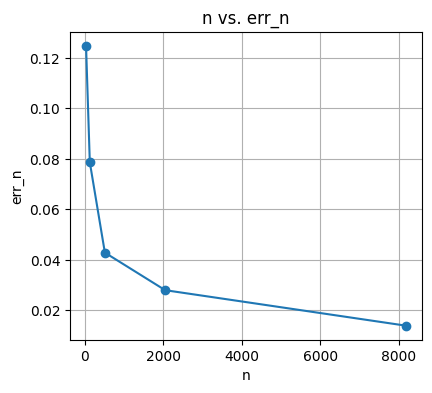

n	Number of Nodes	err_n
32	13		0.1248
128	15		0.0786
512	47		0.0428
2048	123		0.0279
8192	243		0.0138


In [84]:
#PART 3
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Load the data from Dbig.txt
data = np.loadtxt('Dbig.txt')

# Shuffle the data
np.random.seed(32)
perm = np.random.permutation(len(data))
data = data[perm]

# Initialize lists to store results
n_values = [32, 128, 512, 2048, 8192]
num_nodes_list = []
test_errors_list = []

# Split the data into training and testing sets for each n
for n in n_values:
    X_train, y_train = data[:n, :-1], data[:n, -1]
    X_test, y_test = data[n:, :-1], data[n:, -1]

    # Create and train the decision tree classifier
    clf = DecisionTreeClassifier()
    clf.fit(X_train, y_train)

    # Calculate the number of nodes
    num_nodes = clf.tree_.node_count
    num_nodes_list.append(num_nodes)

    # Make predictions on the test data
    y_pred = clf.predict(X_test)

    # Calculate the test error (err_n)
    test_error = 1.0 - accuracy_score(y_test, y_pred)
    test_errors_list.append(test_error)

# Plot n vs. err_n
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(n_values, test_errors_list, marker='o', linestyle='-')
plt.title('n vs. err_n')
plt.xlabel('n')
plt.ylabel('err_n')
plt.grid(True)
plt.show()

# Print results
print("n\tNumber of Nodes\terr_n")
for i in range(len(n_values)):
    print(f"{n_values[i]}\t{num_nodes_list[i]}\t\t{test_errors_list[i]:.4f}")


Without noise:
Train Log Mean Squared Error: 318.52703980176443
Test Log Mean Squared Error: 324.9304715701422

For standard deviation = 0.1:
Train Log Mean Squared Error (after adding noise): 324.71875501526256
Test Log Mean Squared Error (after adding noise): 325.30003239914714


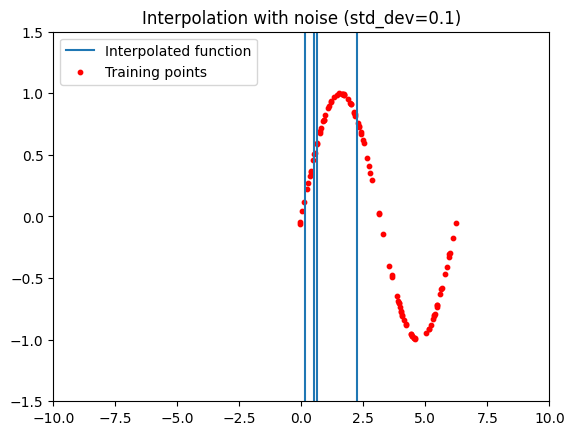


For standard deviation = 0.5:
Train Log Mean Squared Error (after adding noise): 340.0845122487422
Test Log Mean Squared Error (after adding noise): 330.377229233018


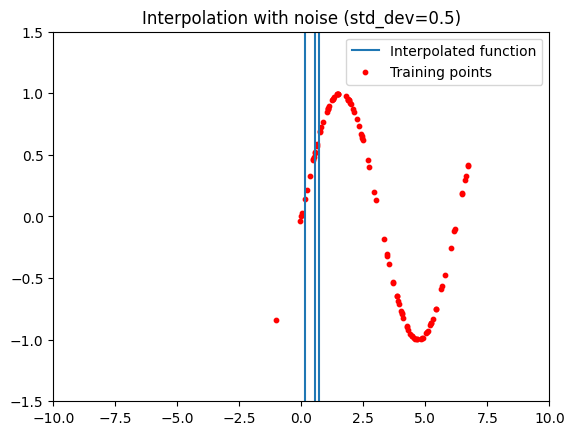


For standard deviation = 1.0:
Train Log Mean Squared Error (after adding noise): 339.72459318728073
Test Log Mean Squared Error (after adding noise): 323.1493933766237


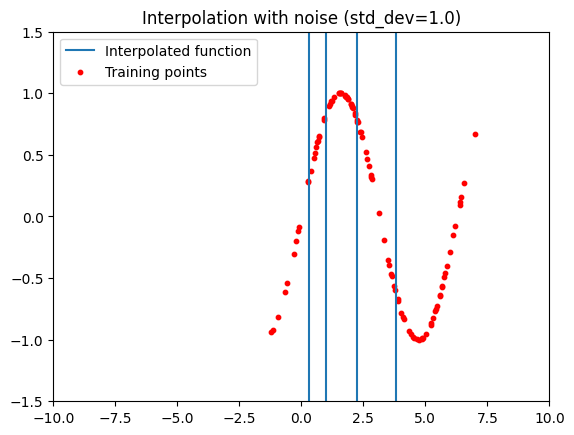


For standard deviation = 5.0:
Train Log Mean Squared Error (after adding noise): 279.40234652173615
Test Log Mean Squared Error (after adding noise): 156.35048647105413


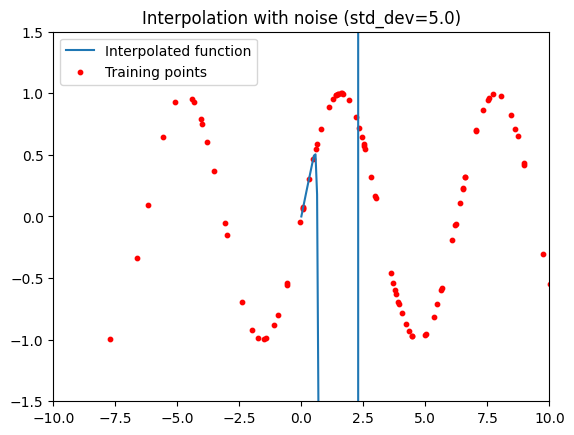


For standard deviation = 25.0:
Train Log Mean Squared Error (after adding noise): 240.35047762471038
Test Log Mean Squared Error (after adding noise): -21.69524990134001


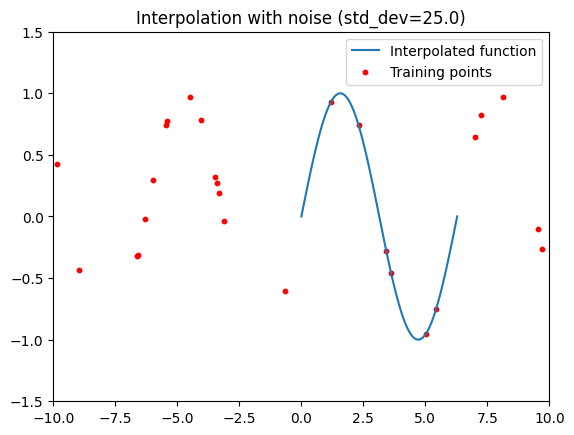

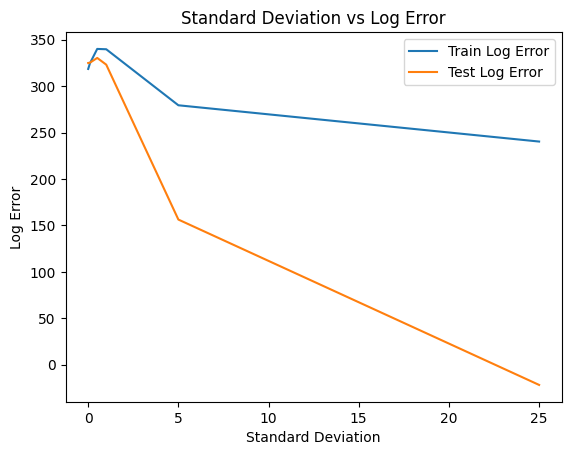

In [86]:
#PART 4

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import lagrange
from sklearn.metrics import mean_squared_error

# Fix interval [a,b]
a = 0
b = 2*np.pi
n = 100

# Create a training set
x_train = np.random.uniform(a, b, n)
y_train = np.sin(x_train) # sine of x

# Train a model using Lagrange interpolation
f = lagrange(x_train, y_train)

# Create a test set
x_test = np.random.uniform(a, b, n)
y_test = np.sin(x_test)

# Predict on train and test set
y_train_pred = f(x_train)
y_test_pred = f(x_test)

# Compute the log mean squared error
train_mse = np.log(mean_squared_error(y_train, y_train_pred))
test_mse = np.log(mean_squared_error(y_test, y_test_pred))

print('Without noise:')
print('Train Log Mean Squared Error:', train_mse)
print('Test Log Mean Squared Error:', test_mse)

# Initialize train and test errors
train_log_errors = [train_mse]
test_log_errors = [test_mse]

std_devs = [0, 0.1, 0.5, 1.0, 5.0, 25.0] # standard deviations

for std_dev in std_devs[1:]:

    # Add Gaussian noise to x_train
    epsilon = np.random.normal(0, std_dev, n)
    x_train_noise = x_train + epsilon
    y_train_noise = np.sin(x_train_noise)

    # Train a model using Lagrange interpolation with noisy data
    f_noise = lagrange(x_train_noise, y_train_noise)

    # Predict on noisy train and original test set
    y_train_pred_noise = f_noise(x_train_noise)
    y_test_pred_noise = f_noise(x_test)

    # Compute the log mean squared error
    train_mse_noise = np.log(mean_squared_error(y_train_noise, y_train_pred_noise))
    test_mse_noise = np.log(mean_squared_error(y_test, y_test_pred_noise))

    print(f'\nFor standard deviation = {std_dev}:')
    print('Train Log Mean Squared Error (after adding noise):', train_mse_noise)
    print('Test Log Mean Squared Error (after adding noise):', test_mse_noise)

    # Append the log error values to the lists
    train_log_errors.append(train_mse_noise)
    test_log_errors.append(test_mse_noise)

    # Plot the results
    x_range = np.linspace(a, b, n)
    y_pred_range = f_noise(x_range)
    plt.plot(x_range, y_pred_range, label='Interpolated function')
    plt.scatter(x_train_noise, y_train_noise, color='red', s=10, label='Training points')
    plt.ylim(-1.5, 1.5)
    plt.xlim(-10,10)
    plt.legend()
    plt.title(f'Interpolation with noise (std_dev={std_dev})')
    plt.show()


# Plot the results
plt.plot(std_devs, train_log_errors, label='Train Log Error')
plt.plot(std_devs, test_log_errors, label='Test Log Error')
plt.xlabel('Standard Deviation')
plt.ylabel('Log Error')
plt.title('Standard Deviation vs Log Error')
plt.legend()
plt.show()
